In [80]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import Optional

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

In [2]:
def make_synthetic_dataset(n: int = 10000, rng_seed: int = 12435):
    rng = np.random.RandomState(rng_seed)
    
    x = rng.uniform(low=-1.0, high=+1.0, size=(n, 3))
    
    # Simple function for the mean of the target
    y_zero_noise = x[:, 0] - x[:, 1]
    
    # Also simple function for the stddev. Ranges from 1 to 3
    sigma = 2.0 + x[:, 2]
    eps = sigma * rng.normal(loc=0.0, scale=1.0)
    
    y_with_noise = y_zero_noise + eps
    
    return x, y_zero_noise

In [47]:
def get_models():
    mu_model = nn.Linear(in_features=3, out_features=1, bias=True)

    sigma_model = nn.Sequential(
        nn.Linear(in_features=3, out_features=1, bias=True),
        nn.Softplus(beta=1)
    )
    
    return mu_model, sigma_model

In [48]:
def get_dataloader():
    x_data, y_data = make_synthetic_dataset()
    dataset = TensorDataset(torch.Tensor(x_data), torch.Tensor(y_data))
    dataloader = DataLoader(dataset, shuffle=True, batch_size=128)
    
    return dataloader

In [87]:
def train_model(n_epochs: int = 100, lr: float = 1e-2, alternating_training: bool = False,
               clip_gradients: Optional[float] = 1e-1):
    mu_model, sigma_model = get_models()
    dataloader = get_dataloader()
    
    optimizer_mu = torch.optim.SGD(params=mu_model.parameters(), lr=lr)
    optimizer_sigma = torch.optim.SGD(params=sigma_model.parameters(), lr=lr)
    loss_history = []
    
    train_mu_model = True
    train_sigma_model = not alternating_training

    for epoch in range(n_epochs):
        # Train
        if train_mu_model:
            mu_model.train()
        else:
            mu_model.eval()
        if train_sigma_model:
            sigma_model.train()
        else:
            sigma_model.eval()

        total_loss = 0.0
        total_n = 0

        for x, y in iter(dataloader):
            y_hat = mu_model.forward(x).squeeze(dim=1)
            sigma_hat = sigma_model.forward(x).squeeze(dim=1)

            loss = torch.log(sigma_hat) + 0.5 * (sigma_hat**(-2)) * (y - y_hat)**2

            loss = loss.mean(dim=0)

            optimizer_mu.zero_grad()
            optimizer_sigma.zero_grad()
            loss.backward()
            if clip_gradients:
                torch.nn.utils.clip_grad_norm_(mu_model.parameters(), clip_gradients)
                torch.nn.utils.clip_grad_norm_(sigma_model.parameters(), clip_gradients)
            if train_mu_model:
                optimizer_mu.step()
            if train_sigma_model:
                optimizer_sigma.step()

            total_loss += loss.item()
            total_n += x.size(0)

        total_loss /= total_n
        loss_history.append(total_loss)

        # Swap which model is being trained for the next epoch
        temp = train_mu_model
        train_mu_model = train_sigma_model
        train_sigma_model = temp
    
    return loss_history

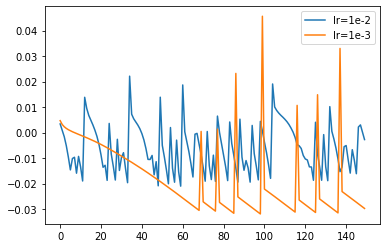

In [85]:
# Pure gradient descent.
# Very unstable.

res_2 = train_model(n_epochs=150, lr=1e-2, clip_gradients=None)
res_3 = train_model(n_epochs=150, lr=1e-3, clip_gradients=None)
plt.plot(res_2, label='lr=1e-2')
plt.plot(res_3, label='lr=1e-3')
plt.legend()

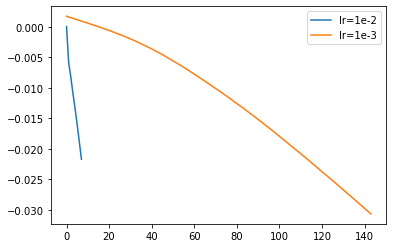

In [88]:
# Try alternating which model we train.
# Better, but large learning rate gives us NaNs.
res_2 = train_model(n_epochs=150, lr=1e-2, clip_gradients=None, alternating_training=True)
res_3 = train_model(n_epochs=150, lr=1e-3, clip_gradients=None, alternating_training=True)
plt.plot(res_2, label='lr=1e-2')
plt.plot(res_3, label='lr=1e-3')
plt.legend()

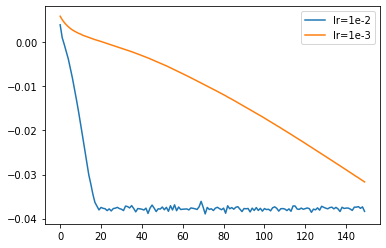

In [91]:
# Alternating which model we traing AND clipping gradients.
# Ok, but we'll see we can find lower losses below.
res_2 = train_model(n_epochs=150, lr=1e-2, clip_gradients=1.0, alternating_training=True)
res_3 = train_model(n_epochs=150, lr=1e-3, clip_gradients=1.0, alternating_training=True)
plt.plot(res_2, label='lr=1e-2')
plt.plot(res_3, label='lr=1e-3')
plt.legend()

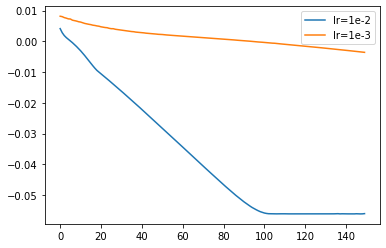

In [94]:
# Smaller gradient clip, train both models at once.
# Best result I've found so far.
res_2 = train_model(n_epochs=150, lr=1e-2, clip_gradients=1e-1)
res_3 = train_model(n_epochs=150, lr=1e-3, clip_gradients=1e-1)
plt.plot(res_2, label='lr=1e-2')
plt.plot(res_3, label='lr=1e-3')
plt.legend()

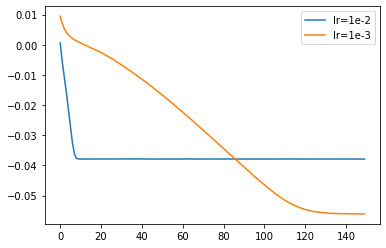

In [93]:
# Higher learning rate gets stuck!
res_2 = train_model(n_epochs=150, lr=1e-2, clip_gradients=1.0, alternating_training=False)
res_3 = train_model(n_epochs=150, lr=1e-3, clip_gradients=1.0, alternating_training=False)
plt.plot(res_2, label='lr=1e-2')
plt.plot(res_3, label='lr=1e-3')
plt.legend()

Notes:
* Gradient clipping to `1e-1` for both models with a learning rate of `1e-2` seems to learn well.